## 非监督学习: 创建用户分类

这个项目的数据集能够在[UCI机器学习信息库](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers)中找到.因为这个项目的目的，分析将不会包括'Channel'和'Region'这两个特征——重点集中在6个记录的客户购买的产品类别上。

In [12]:
# 引入需要的库
import numpy as np
import pandas as pd
import visuals as vs
from IPython.display import display 

%matplotlib inline

data = pd.read_csv("customers.csv")
data.drop(['Region', 'Channel'], axis = 1, inplace = True)

## 分析数据
意这个数据集包含了6个重要的产品类型：**'Fresh'**, **'Milk'**, **'Grocery'**, **'Frozen'**, **'Detergents_Paper'**和 **'Delicatessen'**。

In [16]:
# 显示数据集的描述
display(data.describe())

Fresh          Milk       Grocery        Frozen  \
count     440.000000    440.000000    440.000000    440.000000   
mean    12000.297727   5796.265909   7951.277273   3071.931818   
std     12647.328865   7380.377175   9503.162829   4854.673333   
min         3.000000     55.000000      3.000000     25.000000   
25%      3127.750000   1533.000000   2153.000000    742.250000   
50%      8504.000000   3627.000000   4755.500000   1526.000000   
75%     16933.750000   7190.250000  10655.750000   3554.250000   
max    112151.000000  73498.000000  92780.000000  60869.000000   

       Detergents_Paper  Delicatessen  
count        440.000000    440.000000  
mean        2881.493182   1524.870455  
std         4767.854448   2820.105937  
min            3.000000      3.000000  
25%          256.750000    408.250000  
50%          816.500000    965.500000  
75%         3922.000000   1820.250000  
max        40827.000000  47943.000000

选择几个样本数据点，并且更为详细地分析它们。选择**三个**索引加入到索引列表`indices`中。

In [18]:

indices = [4,23,76]

# 为选择的样本建立一个DataFrame
samples = pd.DataFrame(data.loc[indices], columns = data.keys()).reset_index(drop = True)
print("Chosen samples of wholesale customers dataset:")
display(samples)

Chosen samples of wholesale customers dataset:


Fresh   Milk  Grocery  Frozen  Detergents_Paper  Delicatessen
0  22615   5410     7198    3915              1777          5185
1  26373  36423    22019    5154              4337         16523
2    717   3587     6532    7530               529           894


可以看出，选取的3个样本点中，第一个是零售商，主要出售生鲜的零售商，生鲜进货量大，其他产品进货量小。
第二个是超市，因为购买总量巨大，且生鲜，奶制品，杂货的数量比较平均。第三个是咖啡店，奶制品，杂货，冷冻购入量大，生鲜，熟食，纸巾少。

## 特征相关性
考虑这六个类别中的一个（或者多个）产品类别，是否对于理解客户的购买行为具有实际的相关性。有一个简单的方法可以检测相关性：我们用移除了某一个特征之后的数据集来构建一个监督学习（回归）模型，然后用这个模型去预测那个被移除的特征，再对这个预测结果进行评分，看看预测结果如何。


In [20]:
new_data = data.drop('Fresh',axis=1)
new_data_item = data['Fresh']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(new_data, new_data_item, test_size=0.25, random_state=10)

# 创建一个决策树回归器并在训练集上训练它
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state=8)
regressor.fit(X_train, y_train)

score = regressor.score(X_test, y_test)
score

-0.34538945458746406

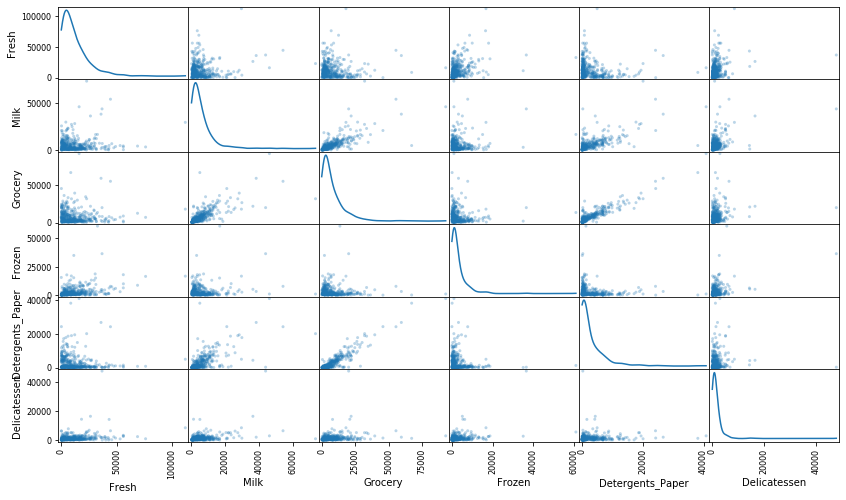

In [21]:
# 对于数据中的每一对特征构造一个散布矩阵
pd.plotting.scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

 就图而言，'Milk','Grocery','Detergents_Paper'彼此之间存在一定程度相关性。这个结果验证了我预测的特征的相关性，'Fresh'与其他特征的相关性不大。特征之间相关性强的呈正态分布，相关性不强的特征分布规律性不强。


## 数据预处理
在这个部分，你将通过在数据上做一个合适的缩放，并检测异常点（你可以选择性移除）将数据预处理成一个更好的代表客户的形式。

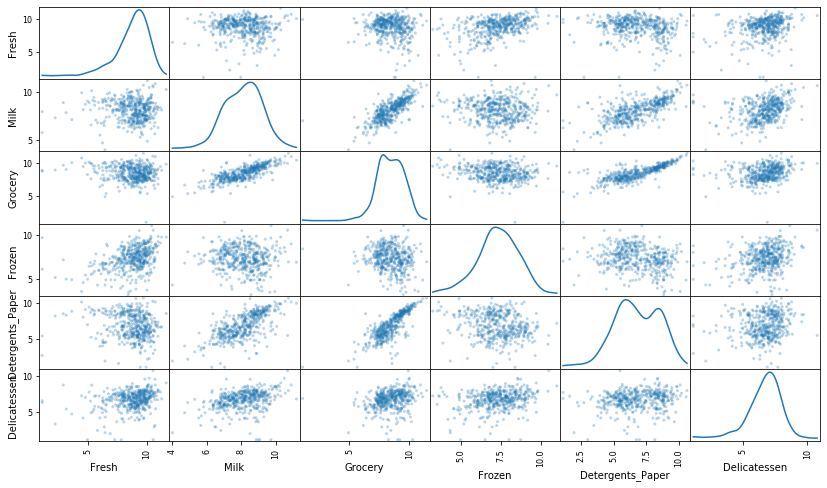

In [22]:
# 使用自然对数缩放数据
log_data = np.log(data)

# 使用自然对数缩放样本数据
log_samples = np.log(samples)

# 为每一对新产生的特征制作一个散射矩阵
pd.plotting.scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

### 观察
在使用了一个自然对数的缩放之后，数据的各个特征会显得更加的正态分布。对于任意的你以前发现有相关关系的特征对，观察他们的相关关系是否还是存在的（并且尝试观察，他们的相关关系相比原来是变强了还是变弱了）。

运行下面的代码以观察样本数据在进行了自然对数转换之后如何改变了。

In [23]:
# 展示经过对数变换后的样本数据
display(log_samples)

Fresh       Milk   Grocery    Frozen  Detergents_Paper  Delicatessen
0  10.026369   8.596004  8.881558  8.272571          7.482682      8.553525
1  10.180096  10.502956  9.999661  8.547528          8.374938      9.712509
2   6.575076   8.185071  8.784468  8.926650          6.270988      6.795706

In [27]:
# 对于每一个特征，找到值异常高或者是异常低的数据点
for feature in log_data.keys():
    
    # 计算给定特征的Q1（数据的25th分位点）
    Q1 = np.percentile(log_data[feature] , 25)
    
    # 计算给定特征的Q3（数据的75th分位点）
    Q3 = np.percentile(log_data[feature] , 75)
    
    # 使用四分位范围计算异常阶（1.5倍的四分位距）
    step = 1.5*(Q3 - Q1)
    
    # 显示异常点
    print("Data points considered outliers for the feature '{}':".format(feature))
    display(log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))])
    
# 选择你希望移除的数据点的索引
outliers  = [66,75,154]

# 如果选择了的话，移除异常点
good_data = log_data.drop(log_data.index[outliers]).reset_index(drop = True)

Data points considered outliers for the feature 'Fresh':


Fresh       Milk    Grocery    Frozen  Detergents_Paper  Delicatessen
65   4.442651   9.950323  10.732651  3.583519         10.095388      7.260523
66   2.197225   7.335634   8.911530  5.164786          8.151333      3.295837
81   5.389072   9.163249   9.575192  5.645447          8.964184      5.049856
95   1.098612   7.979339   8.740657  6.086775          5.407172      6.563856
96   3.135494   7.869402   9.001839  4.976734          8.262043      5.379897
128  4.941642   9.087834   8.248791  4.955827          6.967909      1.098612
171  5.298317  10.160530   9.894245  6.478510          9.079434      8.740337
193  5.192957   8.156223   9.917982  6.865891          8.633731      6.501290
218  2.890372   8.923191   9.629380  7.158514          8.475746      8.759669
304  5.081404   8.917311  10.117510  6.424869          9.374413      7.787382
305  5.493061   9.468001   9.088399  6.683361          8.271037      5.351858
338  1.098612   5.808142   8.856661  9.655090          2.708050      6.309918
353  4.762174   8.742574   9.961898  5.429346          9.069007      7.013016
355  5.247024   6.588926   7.606885  5.501258          5.214936      4.844187
357  3.610918   7.150701  10.011086  4.919981          8.816853      4.700480
412  4.574711   8.190077   9.425452  4.584967          7.996317      4.127134

Data points considered outliers for the feature 'Milk':


Fresh       Milk    Grocery    Frozen  Detergents_Paper  Delicatessen
86   10.039983  11.205013  10.377047  6.894670          9.906981      6.805723
98    6.220590   4.718499   6.656727  6.796824          4.025352      4.882802
154   6.432940   4.007333   4.919981  4.317488          1.945910      2.079442
356  10.029503   4.897840   5.384495  8.057377          2.197225      6.306275

Data points considered outliers for the feature 'Grocery':


Fresh      Milk   Grocery    Frozen  Detergents_Paper  Delicatessen
75   9.923192  7.036148  1.098612  8.390949          1.098612      6.882437
154  6.432940  4.007333  4.919981  4.317488          1.945910      2.079442

Data points considered outliers for the feature 'Frozen':


Fresh      Milk    Grocery     Frozen  Detergents_Paper  Delicatessen
38    8.431853  9.663261   9.723703   3.496508          8.847360      6.070738
57    8.597297  9.203618   9.257892   3.637586          8.932213      7.156177
65    4.442651  9.950323  10.732651   3.583519         10.095388      7.260523
145  10.000569  9.034080  10.457143   3.737670          9.440738      8.396155
175   7.759187  8.967632   9.382106   3.951244          8.341887      7.436617
264   6.978214  9.177714   9.645041   4.110874          8.696176      7.142827
325  10.395650  9.728181   9.519735  11.016479          7.148346      8.632128
420   8.402007  8.569026   9.490015   3.218876          8.827321      7.239215
429   9.060331  7.467371   8.183118   3.850148          4.430817      7.824446
439   7.932721  7.437206   7.828038   4.174387          6.167516      3.951244

Data points considered outliers for the feature 'Detergents_Paper':


Fresh      Milk   Grocery    Frozen  Detergents_Paper  Delicatessen
75   9.923192  7.036148  1.098612  8.390949          1.098612      6.882437
161  9.428190  6.291569  5.645447  6.995766          1.098612      7.711101

Data points considered outliers for the feature 'Delicatessen':


Fresh       Milk    Grocery     Frozen  Detergents_Paper  \
66    2.197225   7.335634   8.911530   5.164786          8.151333   
109   7.248504   9.724899  10.274568   6.511745          6.728629   
128   4.941642   9.087834   8.248791   4.955827          6.967909   
137   8.034955   8.997147   9.021840   6.493754          6.580639   
142  10.519646   8.875147   9.018332   8.004700          2.995732   
154   6.432940   4.007333   4.919981   4.317488          1.945910   
183  10.514529  10.690808   9.911952  10.505999          5.476464   
184   5.789960   6.822197   8.457443   4.304065          5.811141   
187   7.798933   8.987447   9.192075   8.743372          8.148735   
203   6.368187   6.529419   7.703459   6.150603          6.860664   
233   6.871091   8.513988   8.106515   6.842683          6.013715   
285  10.602965   6.461468   8.188689   6.948897          6.077642   
289  10.663966   5.655992   6.154858   7.235619          3.465736   
343   7.431892   8.848509  10.177932   7.283448          9.646593   

     Delicatessen  
66       3.295837  
109      1.098612  
128      1.098612  
137      3.583519  
142      1.098612  
154      2.079442  
183     10.777768  
184      2.397895  
187      1.098612  
203      2.890372  
233      1.945910  
285      2.890372  
289      3.091042  
343      3.610918

## 特征转换
在这个部分中你将使用主成分分析（PCA）来分析批发商客户数据的内在结构。由于使用PCA在一个数据集上会计算出最大化方差的维度，我们将找出哪一个特征组合能够最好的描绘客户。

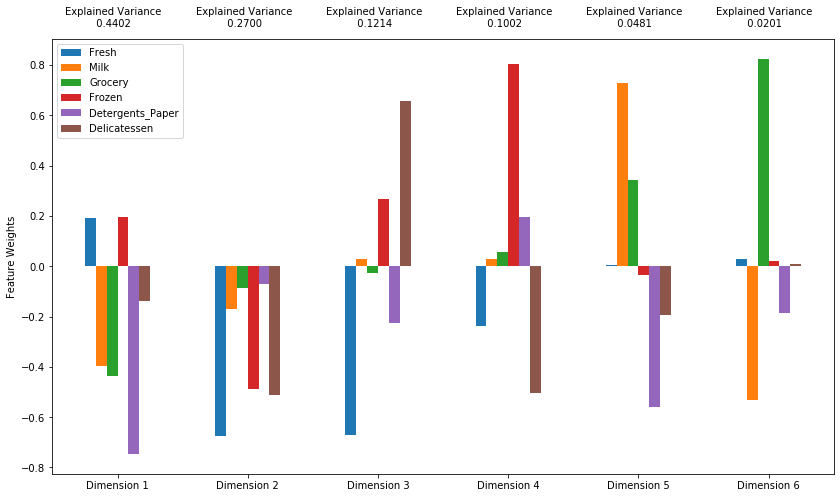

In [28]:
# 通过在good_data上使用PCA，将其转换成和当前特征数一样多的维度
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
pca.fit(good_data)
# 使用上面的PCA拟合将变换施加在log_samples上
pca_samples = pca.transform(log_samples)

# 生成PCA的结果图
pca_results = vs.pca_results(good_data, pca)


可以看出，第一个和第二个主成分总共表示了0.7102的方差，前四个总共表示了0.9318。

Dimension1中Detergents_paper对维度影响最大，Milk,Grocery,Detergents_paper都为负权，有很强的的相关性，同时购买milk，Grocery，Detergents_paper，很可能为咖啡店。

Dimension2中所有特征都为负权，特征之间都有关联性, Fresh,Frozen,Delicatessen对维度影响大，可能是超市。

Dimension3中Fresh和Delicatessen都对维度影响很大，且两个特征之间呈负相关，买Fresh的同时买Delicatessen的可能性极小，应该是零售商。

Dimension4中Frozen对维度影响最大，与Delicatessen呈明显的负相关，应该是其他。

### 观察
运行下面的代码，查看经过对数转换的样本数据在进行一个6个维度的主成分分析（PCA）之后会如何改变。观察样本数据的前四个维度的数值。考虑这和你初始对样本点的解释是否一致。

In [29]:
# 展示经过PCA转换的sample log-data
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values))

Dimension 1  Dimension 2  Dimension 3  Dimension 4  Dimension 5  \
0      -0.6909      -2.4537       0.4778      -0.3011      -0.2880   
1      -2.6773      -3.7654       1.0333      -0.4046       0.7525   
2       0.1249       0.6225       2.0738       1.6747       0.3622   

   Dimension 6  
0       0.0432  
1      -0.1953  
2       0.3135

In [30]:
# 通过在good data上进行PCA，将其转换成两个维度
pca = PCA(n_components=2)
pca.fit(good_data)
# 使用上面训练的PCA将good data进行转换
reduced_data = pca.transform(good_data)

# 使用上面训练的PCA将log_samples进行转换
pca_samples = pca.transform(log_samples)

# 为降维后的数据创建一个DataFrame
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

In [31]:
# 展示经过两个维度的PCA转换之后的样本log-data
display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2']))

Dimension 1  Dimension 2
0      -0.6909      -2.4537
1      -2.6773      -3.7654
2       0.1249       0.6225

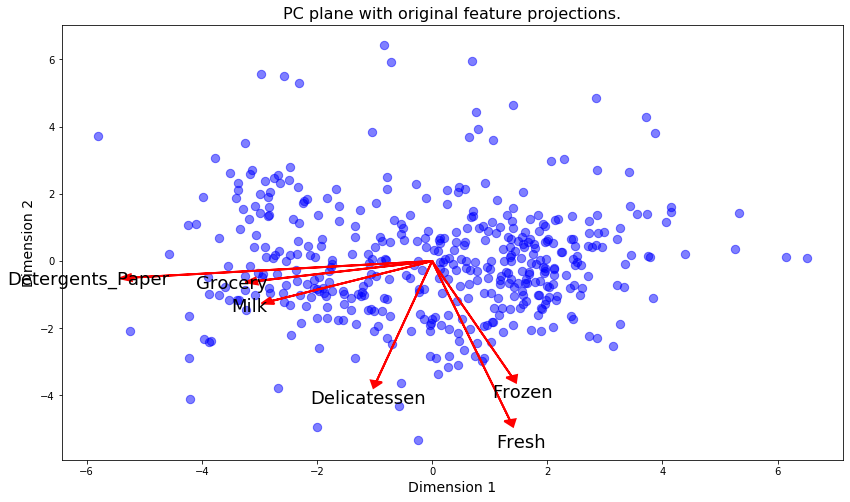

In [33]:
# 可视化双标图
vs.biplot(good_data, reduced_data, pca)

## 聚类

在这个部分，你将选择使用K-Means聚类算法或者是高斯混合模型聚类算法以发现数据中隐藏的客户分类。然后，你将从簇中恢复一些特定的关键数据点，通过将它们转换回原始的维度和规模，从而理解他们的含义。

In [36]:
# 在降维后的数据上使用你选择的聚类算法
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
clusterer = KMeans(random_state=10).fit(reduced_data)
range_n_clusters = [ 2, 3, 4, 5, 6, 7, 8]
optimal_score = -1
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters,random_state=10).fit(reduced_data)
# 预测每一个点的簇
    preds = clusterer.predict(reduced_data)
    
# 找到聚类中心
    centers = clusterer.cluster_centers_

# 预测在每一个转换后的样本点的类
    sample_preds = clusterer.predict(pca_samples)

# 计算选择的类别的平均轮廓系数（mean silhouette coefficient）
    score = silhouette_score(reduced_data, preds)
    print("For n_clusters =", n_clusters, "The average silhouette_score is ", score)
    if optimal_score <= score :
        optimal_score = score
        optimal_preds = preds
        optimal_centers = centers
        optimal_sample_preds = sample_preds
        

For n_clusters = 2 The average silhouette_score is  0.42473989630345754
For n_clusters = 3 The average silhouette_score is  0.3984532495867192
For n_clusters = 4 The average silhouette_score is  0.33309755226135096
For n_clusters = 5 The average silhouette_score is  0.3522550843716758
For n_clusters = 6 The average silhouette_score is  0.36633284525963267
For n_clusters = 7 The average silhouette_score is  0.36621154436069786
For n_clusters = 8 The average silhouette_score is  0.3631899248987062


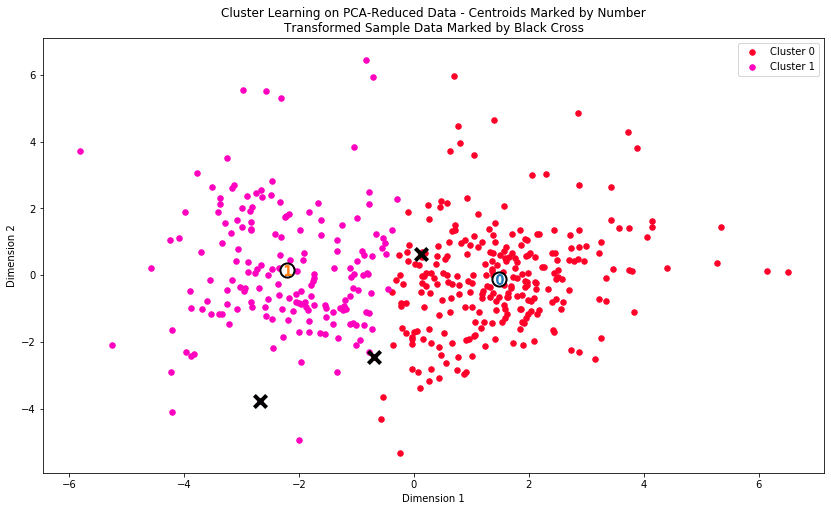

In [38]:
# 展示聚类的结果
vs.cluster_results(reduced_data, optimal_preds, optimal_centers, pca_samples)

In [39]:
#反向转换中心点
log_centers = pca.inverse_transform(optimal_centers)

#对中心点做指数转换
true_centers = np.exp(log_centers)

# 显示真实的中心点
segments = ['Segment {}'.format(i) for i in range(0,len(optimal_centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.keys())
true_centers.index = segments
display(true_centers)

Fresh    Milk  Grocery  Frozen  Detergents_Paper  Delicatessen
Segment 0  9047.0  1927.0   2508.0  2118.0             301.0         689.0
Segment 1  3681.0  7954.0  12217.0   893.0            4629.0         995.0

In [42]:
# 显示预测结果
for i, pred in enumerate(optimal_sample_preds):
    print("Sample point", i, "predicted to be in Cluster", optimal_sample_preds[i])

Sample point 0 predicted to be in Cluster 1
Sample point 1 predicted to be in Cluster 1
Sample point 2 predicted to be in Cluster 0


**回答:** 样本0和样本1能够被Cluster 1标识，样本2能够被Cluster 2标识，与之前对样本的预测基本符合。

## 结论

在最后一部分中，你要学习如何使用已经被分类的数据。首先，你要考虑不同组的客户**客户分类**，针对不同的派送策略受到的影响会有什么不同。其次，你要考虑到，每一个客户都被打上了标签（客户属于哪一个分类）可以给客户数据提供一个多一个特征。最后，你会把客户分类与一个数据中的隐藏变量做比较，看一下这个分类是否辨识了特定的关系。

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# 读取包含聚类结果的数据
cluster_data = pd.read_csv("cluster.csv")
y = cluster_data['Region']
X = cluster_data.drop(['Region'], axis = 1)

# 划分训练集测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

clf = RandomForestClassifier(random_state=24)
clf.fit(X_train, y_train)
print("使用cluster特征的得分", clf.score(X_test, y_test))

# 移除cluster特征
X_train = X_train.copy()
X_train.drop(['cluster'], axis=1, inplace=True)
X_test = X_test.copy()
X_test.drop(['cluster'], axis=1, inplace=True)
clf.fit(X_train, y_train)
print("不使用cluster特征的得分", clf.score(X_test, y_test))

使用cluster特征的得分 0.6666666666666666
不使用cluster特征的得分 0.6436781609195402


/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


 使用cluster特征比不使用cluster特征的预估效果好。因此在进行预估时，利用聚类技术进行预估时会比自己估算的效果好。

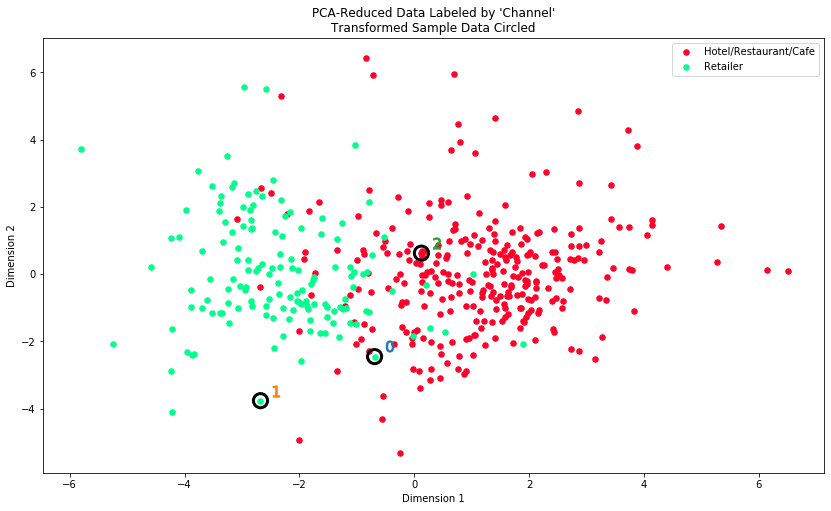

In [46]:
# 根据‘Channel‘数据显示聚类的结果
vs.channel_results(reduced_data, outliers, pca_samples)